In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt


movies='ml-latest/movies.csv'
ratings='ml-latest/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId','movieId','rating'], dtype={'userId':'int32','movieId':'int32','rating':'float32'})


In [4]:
def setup_recommender(data, model):
    model.fit(data)

In [5]:
#save for later use



# def recommender(movie_name, df_movies, data, model, n_recommendations):
#     # Find the best matching movie index using fuzzy matching
#     idx = process.extractOne(movie_name, df_movies['title'], score_cutoff=70)
#     if idx:
#         movie_idx = idx[2]
#         print(f"Movie Selected: {df_movies['title'][movie_idx]}, Index: {movie_idx}")
#         print('Searching for recommendations...')
#         distances, indices = model.kneighbors(data[movie_idx], n_neighbors=n_recommendations)
#         recommendations = [df_movies['title'][i] for i in indices.flatten() if i != movie_idx]
        
#         # Print all recommendations at once
#         print("\nRecommended Movies:")
#         for title in recommendations:
#             print(title)
#     else:
#         print("No matching movie found. Please try another name.")

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

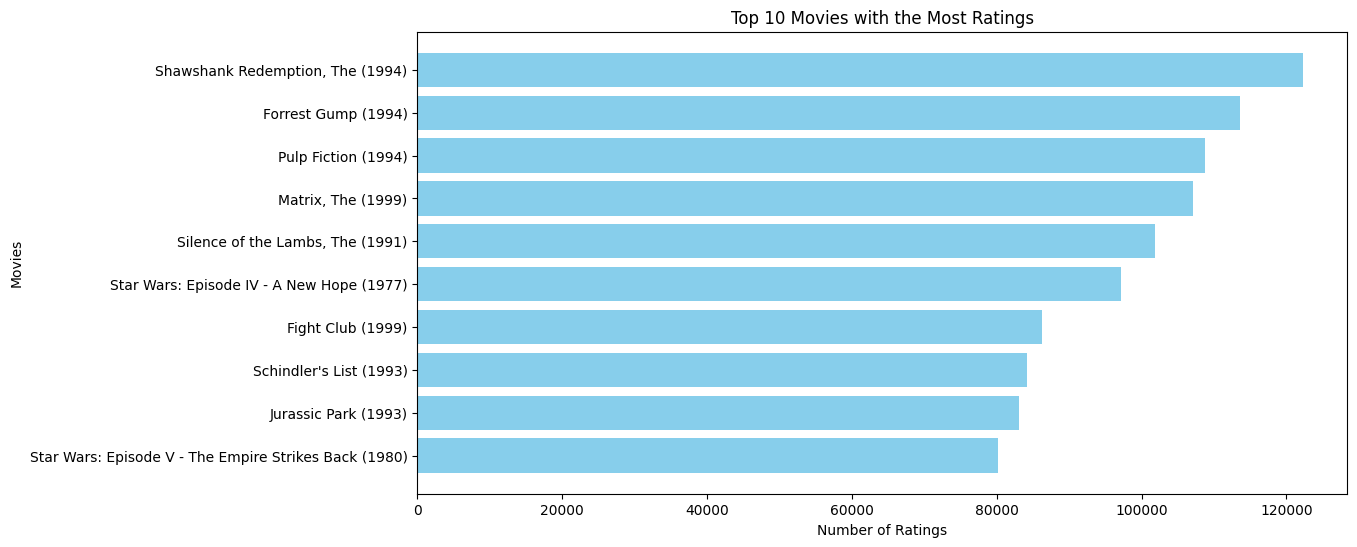

In [6]:
#Aggregate the ratings to count the number of ratings per movie
rating_counts = df_ratings.groupby('movieId').size().reset_index(name='count')

#Merge with the df_movies to get the movie titles
movie_ratings = pd.merge(df_movies, rating_counts, on='movieId')

# Sort the movies by the number of ratings, descending, and select the top 10
top_movies = movie_ratings.sort_values(by='count', ascending=False).head(10)

# plot the top 10 movies with the most ratings
plt.figure(figsize=(12, 6))
plt.barh(top_movies['title'], top_movies['count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.title('Top 10 Movies with the Most Ratings')
plt.gca().invert_yaxis()  # This inverts the y-axis so the movie with the most ratings is at the top
plt.show()

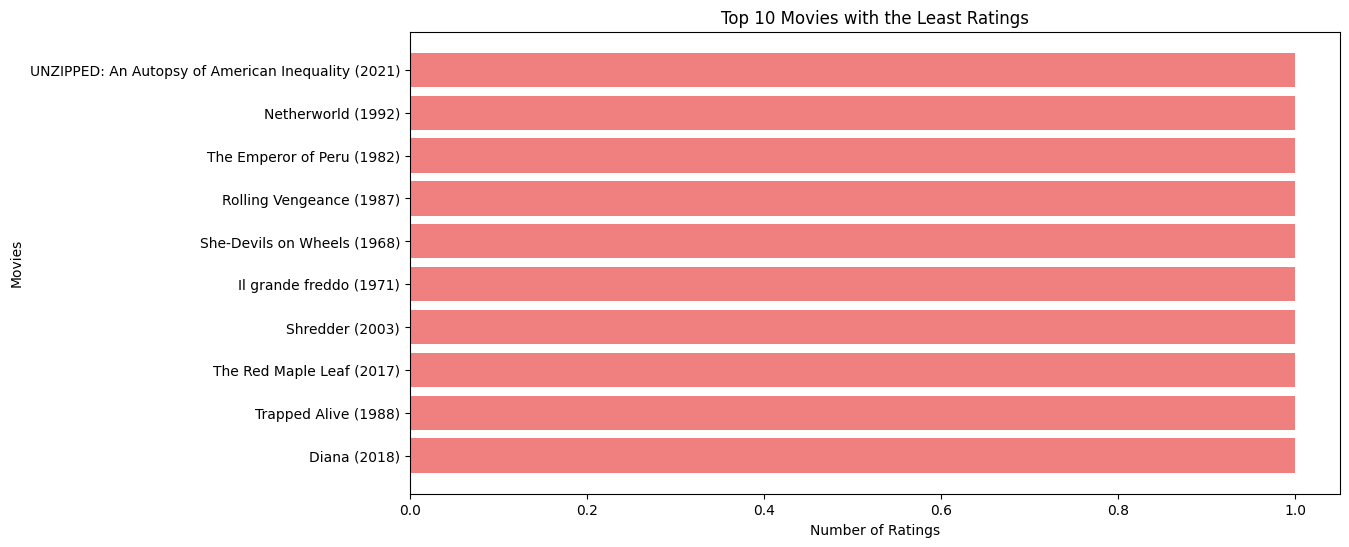

In [7]:
#Movies with least ratings. could also be least viewed?
bottom_movies = movie_ratings.sort_values(by='count', ascending=True).head(10)


plt.figure(figsize=(12, 6))
plt.barh(bottom_movies['title'], bottom_movies['count'], color='lightcoral')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.title('Top 10 Movies with the Least Ratings')
plt.gca().invert_yaxis()  # This inverts the y-axis so the movie with the least ratings is at the bottom
plt.show()

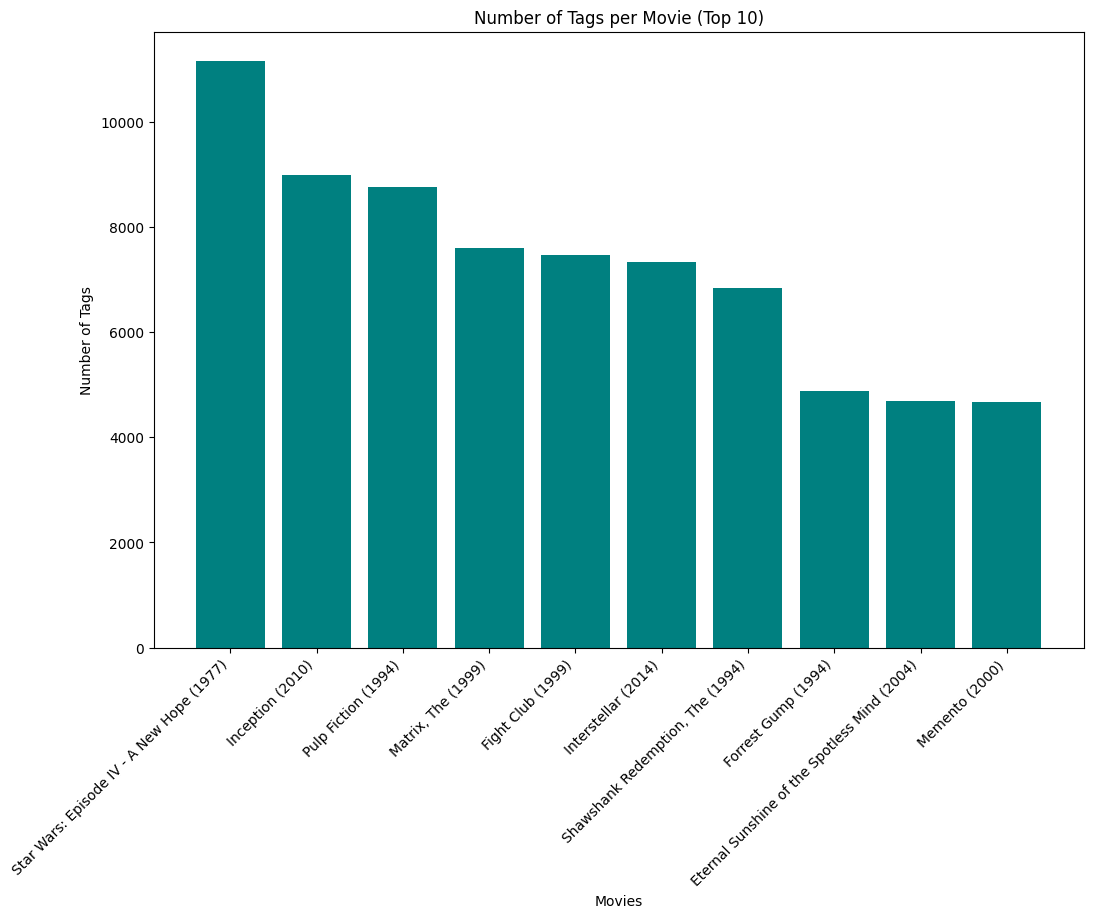

In [10]:
#amount of tags per movie. top 10
df_tags = pd.read_csv('ml-latest/tags.csv', usecols=['movieId', 'tag'])

tag_counts = df_tags.groupby('movieId').size().reset_index(name='count')

movie_tags = pd.merge(df_movies, tag_counts, on='movieId', how='left').fillna(0)


movie_tags_sorted = movie_tags.sort_values(by='count', ascending=False)

#plot the top 10 movies with the most tags
plt.figure(figsize=(12, 8))
plt.bar(movie_tags_sorted['title'].head(10), movie_tags_sorted['count'].head(10), color='teal')
plt.xlabel('Movies')
plt.ylabel('Number of Tags')
plt.title('Number of Tags per Movie (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()